In [10]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

# ===============================
# 1️⃣ Load & Xử lý dữ liệu
# ===============================
# Đọc dữ liệu
df = pd.read_csv("full_data_imputed.csv", index_col=False)

# Xử lý cột thừa
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df_copy = df.copy()
df_copy['Local Time'] = pd.to_datetime(df_copy['Local Time'])

# Set index & Fill missing weather data
df_copy = df_copy.set_index('Local Time')
weather_cols = ['Clouds', 'Precipitation', 'Pressure', 'Relative Humidity', 'Temperature', 'UV_Index', 'Wind Speed']
df_copy[weather_cols] = df_copy[weather_cols].ffill().bfill()

# Feature Engineering
df_copy['Month'] = df_copy.index.month
df_copy['Day'] = df_copy.index.day
df_copy['Hour'] = df_copy.index.hour
df_copy['Weekday'] = df_copy.index.weekday

# Xóa các cột không cần thiết
for col in ['Latitude', 'Longitude']:
    if col in df_copy.columns:
        df_copy.drop(col, axis=1, inplace=True)

print("Kích thước dữ liệu:", df_copy.shape)

# ===============================
# 2️⃣ Chia train/val/test
# ===============================
train_data = df_copy.loc['2023':'2024']
val_data = df_copy.loc['2025-01':'2025-06']
test_data = df_copy.loc['2025-07':'2025-09']

target_col = 'Aqi'

X_train, y_train = train_data.drop(columns=[target_col]), train_data[target_col]
X_val, y_val = val_data.drop(columns=[target_col]), val_data[target_col]
X_test, y_test = test_data.drop(columns=[target_col]), test_data[target_col]

# ===============================
# 3️⃣ Scale dữ liệu
# ===============================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# ===============================
# 4️⃣ Tạo dataset
# ===============================
length = 24  # 24 giờ quá khứ
batch_size = 32
n_features = X_train_scaled.shape[1]

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train_scaled, targets=y_train_scaled, sequence_length=length, batch_size=batch_size, shuffle=False
)
val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val_scaled, targets=y_val_scaled, sequence_length=length, batch_size=batch_size, shuffle=False
)
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test_scaled, targets=y_test_scaled, sequence_length=length, batch_size=batch_size, shuffle=False
)

# ===============================
# 5️⃣ Custom metrics
# ===============================
def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return tf.sqrt(msle(y_true, y_pred))

def r2_keras(y_true, y_pred):
    y_pred = tf.cast(y_pred, y_true.dtype)
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# ===============================
# 6️⃣ MODEL TRANSFORMER (Đã FIX LỖI SHAPE)
# ===============================

# Class 1: Positional Encoding (Sửa lại dùng Static Shape để tránh lỗi Flatten)
class TimeSeriesEmbedding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.sequence_length = sequence_length # Lưu lại độ dài cố định
        self.d_model = d_model
        self.feature_projection = layers.Dense(d_model)
        self.position_embedding = layers.Embedding(input_dim=sequence_length, output_dim=d_model)

    def call(self, inputs):
        # Thay vì dùng tf.shape(inputs)[1] (dynamic), ta dùng self.sequence_length (static)
        # Điều này giúp TensorFlow biết chính xác kích thước tensor
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)

        x = self.feature_projection(inputs)
        encoded = x + self.position_embedding(positions)
        return encoded

# Hàm 2: Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# Hàm 3: Build Model
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)

    # 1. Nhúng thời gian
    x = TimeSeriesEmbedding(sequence_length=input_shape[0], d_model=head_size)(inputs)

    # 2. Các lớp Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # 3. FIX QUAN TRỌNG: Thay Flatten bằng Global Pooling kép
    # Flatten dễ gây lỗi shape động. Ta dùng kết hợp Average (xu hướng) và Max (đỉnh nhọn)
    # Cách này cực kỳ hiệu quả cho bài toán AQI (vừa cần biết trung bình, vừa cần biết lúc cao điểm)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])

    # 4. MLP Head
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

# --- Khởi tạo Model ---
# Clear session cũ để tránh rác bộ nhớ
tf.keras.backend.clear_session()

model = build_transformer_model(
    input_shape=(length, n_features),
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=3,
    mlp_units=[64],
    dropout=0.1,
    mlp_dropout=0.1,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # LR 5e-4
    loss='mse',
    metrics=[rmsle_custom, 'mae', 'mse', 'mape', r2_keras]
)

model.summary()

# ===============================
# 7️⃣ Train Model
# ===============================
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

Kích thước dữ liệu: (941433, 19)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_series_embedd… │ (None, 24, 64)    │      2,752 │ input_layer[0][0] │
│ (TimeSeriesEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 64)    │        128 │ time_series_embe… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ time_series_embe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 64)    │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 64)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 64)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 64)    │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 260,673 (1018.25 KB)

 Trainable params: 260,673 (1018.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
print("\n🚀 Bắt đầu train Transformer...")
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[es, plateau],
    verbose=1
)


🚀 Bắt đầu train Transformer...
Epoch 1/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 275s 12ms/step - loss: 0.1638 - mae: 0.2322 - mape: 136.6343 - mse: 0.1638 - r2_keras: -5.1492 - rmsle_custom: 0.0655 - val_loss: 0.2330 - val_mae: 0.3998 - val_mape: 232.1175 - val_mse: 0.2330 - val_r2_keras: -12.2054 - val_rmsle_custom: 0.1429 - learning_rate: 5.0000e-04
Epoch 2/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 255s 12ms/step - loss: 0.0779 - mae: 0.1749 - mape: 121.7418 - mse: 0.0779 - r2_keras: -2.0913 - rmsle_custom: 0.0450 - val_loss: 0.0916 - val_mae: 0.2404 - val_mape: 177.0871 - val_mse: 0.0916 - val_r2_keras: -2.2846 - val_rmsle_custom: 0.0784 - learning_rate: 5.0000e-04
Epoch 3/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 260s 12ms/step - loss: 0.0577 - mae: 0.1274 - mape: 75.3361 - mse: 0.0577 - r2_keras: -0.7776 - rmsle_custom: 0.0390 - val_loss: 0.0363 - val_mae: 0.1576 - val_mape: 125.8964 - val_mse: 0.0363 - val_r2_keras: -0.9124 - val_rmsle_custom: 0.0541 - learning_rate: 5.0000e-04
Epoch 4/50
21421/

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

# ===============================
# 🔟 Dự đoán & Inverse Transform
# ===============================
print("\n------------------------------------------------")
print("Đang tính toán Full Metrics trên tập Test...")
print("------------------------------------------------")

# 1. Dự đoán (Output đang ở dạng Scaled)
y_pred_scaled = model.predict(test_dataset, verbose=0)

# 2. Lấy y_true (Output đang ở dạng Scaled) từ dataset
y_true_scaled = np.concatenate([y for x, y in test_dataset], axis=0)

# 3. Đưa về giá trị gốc (Original Scale)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

# 4. Xử lý giá trị âm (Quan trọng cho MSLE/RMSLE)
# AQI không thể âm, nhưng model có thể dự đoán ra số âm nhỏ.
# Ta cần đưa về 0 để tránh lỗi logarit.
y_pred_safe = np.maximum(y_pred, 0)
y_true_safe = np.maximum(y_true, 0)

# ===============================
# 1️⃣1️⃣ Tính toán 7 Metrics
# ===============================

# 1. MAE
mae = mean_absolute_error(y_true, y_pred)

# 2. MSE
mse = mean_squared_error(y_true, y_pred)

# 3. RMSE
rmse = np.sqrt(mse)

# 4. MSLE (Mean Squared Logarithmic Error)
msle = mean_squared_log_error(y_true_safe, y_pred_safe)

# 5. RMSLE (Root Mean Squared Logarithmic Error)
rmsle = np.sqrt(msle)

# 6. MAPE (Mean Absolute Percentage Error)
# Thêm epsilon (1e-7) để tránh chia cho 0
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100

# 7. R-squared
r2 = r2_score(y_true, y_pred)

# ===============================
# 1️⃣2️⃣ In kết quả Report
# ===============================
print("\n" + "="*50)
print(f"📊 REPORT ĐÁNH GIÁ MÔ HÌNH VMD-CNN-LSTM")
print("="*50)
print(f"{'Metric':<10} | {'Giá trị':<15} | {'Ý nghĩa ngắn gọn'}")
print("-" * 50)
print(f"{'MAE':<10} | {mae:<15.4f} | Sai số tuyệt đối trung bình (đơn vị AQI)")
print(f"{'MSE':<10} | {mse:<15.4f} | Bình phương sai số (phạt lỗi lớn nặng hơn)")
print(f"{'RMSE':<10} | {rmse:<15.4f} | Sai số chuẩn (cùng đơn vị với AQI)")
print(f"{'MSLE':<10} | {msle:<15.4f} | Sai số logarit bình phương")
print(f"{'RMSLE':<10} | {rmsle:<15.4f} | Sai số logarit (tốt nếu dữ liệu chênh lệch lớn)")
print(f"{'MAPE':<10} | {mape:<15.2f}% | Sai số theo phần trăm")
print(f"{'R²':<10} | {r2:<15.4f} | Độ phù hợp (Max = 1.0)")
print("="*50)


------------------------------------------------
Đang tính toán Full Metrics trên tập Test...
------------------------------------------------

📊 REPORT ĐÁNH GIÁ MÔ HÌNH VMD-CNN-LSTM
Metric     | Giá trị         | Ý nghĩa ngắn gọn
--------------------------------------------------
MAE        | 12.0680         | Sai số tuyệt đối trung bình (đơn vị AQI)
MSE        | 286.4227        | Bình phương sai số (phạt lỗi lớn nặng hơn)
RMSE       | 16.9240         | Sai số chuẩn (cùng đơn vị với AQI)
MSLE       | 0.1265          | Sai số logarit bình phương
RMSLE      | 0.3557          | Sai số logarit (tốt nếu dữ liệu chênh lệch lớn)
MAPE       | 36.15          % | Sai số theo phần trăm
R²         | 0.6975          | Độ phù hợp (Max = 1.0)


In [14]:
model.save('transformer_aqi_model.h5')

Model Transformer đã được lưu thành 'transformer_aqi_model.keras'


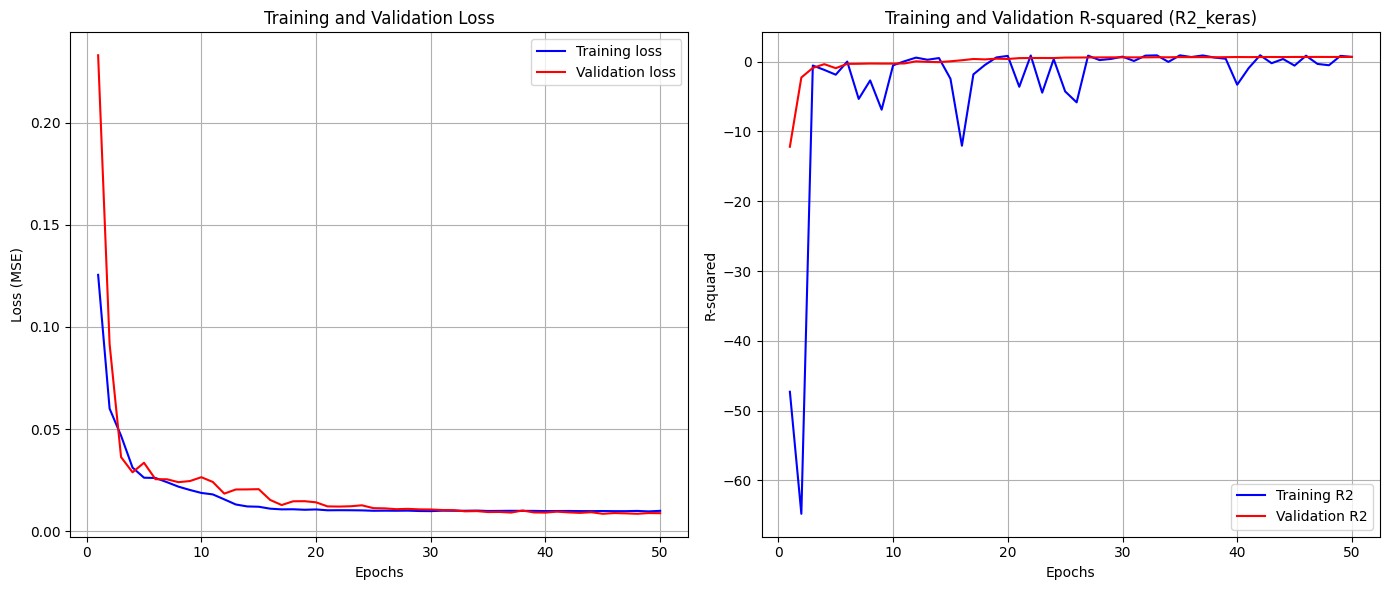

In [15]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ lịch sử huấn luyện
loss = hist.history['loss']
val_loss = hist.history['val_loss']
r2_keras = hist.history['r2_keras']
val_r2_keras = hist.history['val_r2_keras']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot R2_keras
plt.subplot(1, 2, 2)
plt.plot(epochs, r2_keras, 'b', label='Training R2')
plt.plot(epochs, val_r2_keras, 'r', label='Validation R2')
plt.title('Training and Validation R-squared (R2_keras)')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()